## Generate run_files for the stack of offsets

### 1. SLC stack: generate a stack of coregistered SLC using ISCE/topStack SLC workflow

#### ChileSenAT149

```bash
cd ~/nobak/ChileSenAT149
mkdir DEM; cd DEM
dem.py -a stitch -b -24 -19 -71 -66 -r -s 1 -c

# slc stack
stackSentinel.py -s ./SLC/ -d ./DEM/demLat_S24_S19_Lon_W071_W066.dem.wgs84 -b '-21.8 -20.6 -69.6 -67.0' -a /home/zyunjun/bak/aux/aux_cal/ -o /home/zyunjun/bak/aux/aux_poeorb/ -n '1 2 3' -z 1 -r 1 -C geometry -W slc -useGPU

# interferogram stack
stackSentinel.py -s ./SLC/ -d ./DEM/demLat_S24_S19_Lon_W071_W066.dem.wgs84 -b '-21.8 -20.6 -69.6 -67.0' -a /home/zyunjun/bak/aux/aux_cal/ -o /home/zyunjun/bak/aux/aux_poeorb/ -n '1 2 3' -z 10 -r 30 -c 3 -C geometry -W interferogram -useGPU
```

#### SanAndreasSenDT42
```bash
stackSentinel.py -s ./SLC/ -d ./DEM/demLat_N34_N38_Lon_W124_W118.dem.wgs84 -b '35.4 36.5 -121.1 -120' -a /home/zyunjun/bak/aux/aux_cal/ -o /home/zyunjun/bak/aux/aux_poeorb/ -n '1 2' -z 1 -r 1 -C geometry -W slc -useGPU
```

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, network as pnet, readfile, writefile, plot as pp, utils as ut
from mintpy import view

proj_dir = '/Users/yunjunz/data/ChileSenAT149'
os.chdir(proj_dir)
print('Go to directory', proj_dir)

Go to directory /Users/yunjunz/data/ChileSenAT149


### 2. Offset stack: generate a stack of azimuth/range offset using cuDenseOffsets.py

#### 2.1 Generate `date12.list`

In [13]:
### get date12.list
num_conn = 3
date_list_file = os.path.join(proj_dir, 'date.list')
date_list = np.loadtxt(date_list_file, dtype=bytes, usecols=[1]).astype(str).tolist()
date12_list = pnet.select_pairs_sequential(date_list, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')

## job info
num_pair = len(date12_list)
print('number of jobs: {}'.format(num_pair))

gpu_ids = [str(i) for i in [2,3,4,5,6,7]]
num_gpu = len(gpu_ids)
print('number of GPUs: {}'.format(num_gpu))
num_job_per_gpu = np.ceil(num_pair / num_gpu).astype(int)
print('number of jobs per GPU: {}'.format(num_job_per_gpu))

number of jobs: 306
number of GPUs: 6
number of jobs per GPU: 51


#### 2.2 Generate run_offset_gpu_*.sh

+ Run the cell below
+ Copy the run_files to **kamb** and run each of them in different screen.

In [14]:
kamb_proj_dir = '/home/zyunjun/nobak/ChileSenAT149'
## utils function
def get_dense_offset_cmd(proj_dir, date12, gpu_id=None):
    date1, date2 = date12.split('_')
    m_slc = os.path.join(proj_dir, 'merged/SLC/{d}/{d}.slc.full'.format(d=date1))
    s_slc = os.path.join(proj_dir, 'merged/SLC/{d}/{d}.slc.full'.format(d=date2))
    x_file = os.path.join(proj_dir, 'master/IW1.xml')
    prefix = os.path.join(proj_dir, 'merged/offsets/{d}/offset'.format(d=date12))

    cmd = 'cuDenseOffsets.py -m {m} -s {s} --masterxml {x} --outprefix {p} '.format(
        m=m_slc,
        s=s_slc,
        x=x_file,
        p=prefix)
    cmd += ' --kw 300 --kh 100 --nwac 100 --nwdc 1 '
    cmd += ' --ww 256 --wh 256 --sw 10 --sh 10 --raw-osf 2 --corr-osf 64 --redo '

    if gpu_id is not None:
        cmd += ' --gpuid {} '.format(gpu_id)

    return cmd

# run/log_file names and directory
run_files = [os.path.join(proj_dir, 'run_files_offset/run_offset_gpu_{}.sh'.format(i)) for i in gpu_ids]
log_files = [os.path.join(kamb_proj_dir, 'run_files_offset/run_offset_gpu_{}.log'.format(i)) for i in gpu_ids]
run_dir = os.path.dirname(run_files[0])
if not os.path.isdir(run_dir):
    os.makedirs(run_dir)
    print('create directory: {}'.format(run_dir))

# write to run_file: command to create log file
fs = []
for i in range(num_gpu):
    f = open(run_files[i], 'w')
    print('open  file: {} with w mode'.format(run_files[i]))

    cmd = 'touch {}'.format(log_files[i])
    f.write(cmd+'\n')
    #print(cmd)
    fs.append(f)

# write to run_file: command to run cuDenseOffsets.py
for i in range(num_pair):
    gpu_ind = int(i / num_job_per_gpu)
    log_file = log_files[gpu_ind]
    
    cmd = get_dense_offset_cmd(kamb_proj_dir, date12_list[i], gpu_id=gpu_ids[gpu_ind])
    cmd += ' | tee -a {}'.format(log_file)

    f = fs[gpu_ind]
    f.write(cmd+'\n')
    #print(cmd)

# close run_file object
for i in range(num_gpu):
    fs[i].close()
    print('close file:', run_files[i])

# change permission for executables
for i in range(num_gpu):
    cmd = 'chmod +x {}'.format(run_files[i])
    print(cmd)
    os.system(cmd)

open  file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_2.sh with w mode
open  file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_3.sh with w mode
open  file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_4.sh with w mode
open  file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_5.sh with w mode
open  file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_6.sh with w mode
open  file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_7.sh with w mode
close file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_2.sh
close file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_3.sh
close file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_4.sh
close file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_5.sh
close file: /Users/yunjunz/data/ChileSenAT149/run_files_offset/run_offset_gpu_6.sh
close file: /Us

#### 2.3 Mask and filter the offset field

In [9]:
off_dir = '/home/zyunjun/nobak/ChileSenAT149/merged/offsets'     # kamb
off_dir = '/Users/yunjunz/data/ChileSenAT149/merged/offsets'     # laptop

off_files = glob.glob(os.path.join(off_dir,'*/offset.bip'))
num_file = len(off_files)
print('number of offset files: {}'.format(num_file))

!which MaskAndFilter.py

prog_bar = ptime.progressBar(maxValue=num_file)
for i in range(num_file):
    off_file = off_files[i]
    off_dir = os.path.dirname(off_file)
    snr_file = os.path.splitext(off_file)[0] + '_snr.bip'
    cmd = 'MaskAndFilter.py -d {d} -s {s} -t 20 -o {o} '.format(d=off_file, s=snr_file, o=off_dir)
    #print(cmd)
    os.system(cmd)

    date12 = os.path.basename(off_dir)
    prog_bar.update(i+1, suffix=date12)
prog_bar.close()
print('Done.')

number of offset files: 306
/Users/yunjunz/development/python/isce2/contrib/stack/stripmapStack/MaskAndFilter.py
[==================================================] 20150928_20151022  507s /    10s 
Done.


#### 2.4  prepare `geometry` files for offset stack on kamb

```cfg
match_len, match_wid = 256, 256
search_len, search_wid = 10, 10
margin = 50
step_len, step_wid = 100, 300
```

mli_margin = margin + search_len + match_len / 2 = 188

This leads to `$MINTPY_HOME/mintpy/multilook.py -r 300 -a 100 --margin 188 188 188 188`.

Run the following on kamb in the terminal:

```bash
cd ~/nobak/SenDT42F472/merged/geom_master
createWaterMask.py -d ../../DEM/demLat_N34_N38_Lon_W124_W118.dem.wgs84 -l lat.rdr.full -L lon.rdr.full -o waterMask.rdr.full --fill 0

cd ~/nobak/SenDT42F472/merged/offsets/geom_master
multilook.py ../../geom_master/hgt.rdr.full        -r 300 -a 100 --margin 188 188 188 188 -o hgt.rdr
multilook.py ../../geom_master/lat.rdr.full        -r 300 -a 100 --margin 188 188 188 188 -o lat.rdr
multilook.py ../../geom_master/lon.rdr.full        -r 300 -a 100 --margin 188 188 188 188 -o lon.rdr
multilook.py ../../geom_master/los.rdr.full        -r 300 -a 100 --margin 188 188 188 188 -o los.rdr
multilook.py ../../geom_master/shadowMask.rdr.full -r 300 -a 100 --margin 188 188 188 188 -o shadowMask.rdr
multilook.py ../../geom_master/waterMask.rdr.full  -r 300 -a 100 --margin 188 188 188 188 -o waterMask.rdr
```

### 3. Offset time-series

Here is my MintPy configuration file `ChileSenAT149.txt`:

```cfg
# vim: set filetype=cfg:
mintpy.load.processor      = isce  #[isce,snap,gamma,roipac], auto for isce
##---------for ISCE only:
mintpy.load.metaFile       = ../master/IW1.xml  #[path2metadata_file], i.e.: ./master/IW1.xml, ./masterShelve/data.dat
mintpy.load.baselineDir    = ../baselines  #[path2baseline_dir], i.e.: ./baselines
##---------offset datasets:
mintpy.load.azOffFile      = ../merged/offsets/*/filtAz*.off  #[path2az_off_file], optional
mintpy.load.rgOffFile      = ../merged/offsets/*/filtRa*.off  #[path2rg_off_file], optional
mintpy.load.offSnrFile     = ../merged/offsets/*/*_snr*.bip   #[path2off_SNR_file], optional
##---------geometry datasets:
mintpy.load.demFile        = ../merged/offsets/geom_master/hgt.rdr  #[path2hgt_file]
mintpy.load.lookupYFile    = ../merged/offsets/geom_master/lat.rdr  #[path2lat_file], not required for geocoded data
mintpy.load.lookupXFile    = ../merged/offsets/geom_master/lon.rdr  #[path2lon_file], not required for geocoded data
mintpy.load.incAngleFile   = ../merged/offsets/geom_master/los.rdr  #[path2los_file], optional
mintpy.load.azAngleFile    = ../merged/offsets/geom_master/los.rdr  #[path2los_file], optional
mintpy.load.shadowMaskFile = ../merged/offsets/geom_master/shadowMask.rdr  #[path2shadow_file], optional
mintpy.load.waterMaskFile  = ../merged/offsets/geom_master/waterMask.rdr  #[path2water_mask_file], optional

mintpy.network.connNumMax                       = 2
```

#### 3.1 Run simple time series analysis with MintPy

Run the following in the terminal:

```bash
cd /Users/yunjunz/data/ChileSenAT149/mintpyOffset
smallbaselineApp.py ChileSenAT149.txt --end modify_network
ifgram_inversion.py inputs/ifgramStack.h5 -i azimuthOffset -w no -m waterMask.h5 --md offsetSNR --mt 5
ifgram_inversion.py inputs/ifgramStack.h5 -i rangeOffset   -w no -m waterMask.h5 --md offsetSNR --mt 5
reference_date.py timeseriesAz.h5 --ref-date 20200111
reference_date.py timeseriesRg.h5 --ref-date 20200111
timeseries2velocity.py timeseriesAz.h5 -o velocityAz.h5
timeseries2velocity.py timeseriesRg.h5 -o velocityRg.h5
```

#### 3.2 Prepare mask

It should be:
+ pixels with high temporal coherence
+ pixels in land
+ pixels within the reasonable velocity range

Go to directory /Users/yunjunz/data/ChileSenAT149/mintpyOffsetS1A
number of valid pixels: 28182
number of valid pixels after temp_coh_az: 25666
number of valid pixels after temp_coh_rg: 25666
number of valid pixels after water_mask: 25666
number of valid pixels after velocity_az: 19823
number of valid pixels after velocity_rg: 19335
write to file: maskTempCoh.h5
delete exsited file: maskTempCoh.h5
create HDF5 file: maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (122, 231)           with compression=None
finished writing to maskTempCoh.h5


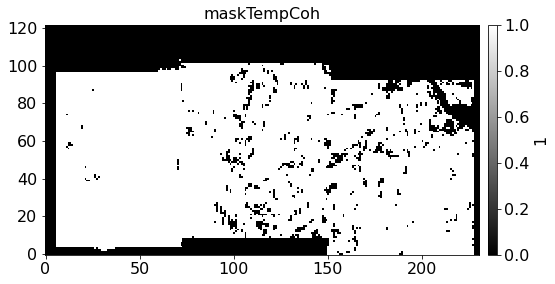

In [10]:
# Go to mintpy directory
#mintpy_dir = os.path.join(proj_dir, 'mintpyOffset')
mintpy_dir = os.path.join(proj_dir, 'mintpyOffsetS1A')
os.chdir(mintpy_dir)
print('Go to directory', mintpy_dir)

# use maskTempCoh.h5 as filename as it's used as the default mask file name in smallbaselineApp.py
mask_file = 'maskTempCoh.h5'

## 1. temporal coherence
min_tcoh = 0.999
tcoh_az = readfile.read('temporalCoherenceAz.h5')[0]
tcoh_rg = readfile.read('temporalCoherenceRg.h5')[0]
mask = np.ones(tcoh_az.shape, dtype=np.bool_)
print('number of valid pixels: {}'.format(np.sum(mask)))
mask *= tcoh_az > min_tcoh
print('number of valid pixels after temp_coh_az: {}'.format(np.sum(mask)))
mask *= tcoh_rg > min_tcoh
print('number of valid pixels after temp_coh_rg: {}'.format(np.sum(mask)))

## 2. water
water_mask = readfile.read('waterMask.h5')[0]
mask *= water_mask
print('number of valid pixels after water_mask: {}'.format(np.sum(mask)))

## 3. velocity
vel_az = readfile.read('velocityAz.h5', datasetName='velocity')[0]
vel_rg = readfile.read('velocityRg.h5', datasetName='velocity')[0]
mask *= vel_az > 0.10
print('number of valid pixels after velocity_az: {}'.format(np.sum(mask)))
mask *= vel_rg < -0.10
print('number of valid pixels after velocity_rg: {}'.format(np.sum(mask)))

### for swath 1 only
#xmax = 70
#mask[:,xmax:] = 0

## write to file
print('write to file: {}'.format(mask_file))
atr = readfile.read_attribute('temporalCoherenceAz.h5')
atr['FILE_TYPE'] = 'mask'
atr['DATA_TYPE'] = 'bool'
atr['UNIT'] = '1'
writefile.write(mask, out_file=mask_file, metadata=atr)

# plot
view.main('maskTempCoh.h5 -c gray --noverbose'.split())

#### 3.3 Add aux info - cross S1A/B, IPF, etc.

In [14]:
def get_S1AB_from_SAFE_file(safe_list_file, ts_file, out_file=None):
    """Get list of Sentinel-1A or Sentinel-1B for each acquisition from the list of SAFE filenames.

    Since not all the SAFE list file are used, due to the bbox argument, ts_file is required to 
    grab the actual dates.

    Parameters: safe_list_file - str, txt file path for the SAFE file names
                ts_file        - str, time-series HDF5 filename
                out_file       - str, output txt file name
    Returns:    dates          - list of str, date in YYYYMMDD format
                sensors        - list of str, A or B
                fnames         - list of str, SAFE filenames
    Examples: 
        !cd ~/nobak/ChileSenAT149
        !ls SLC/S1*.zip > SLC/SAFE.list
        dates, sensors, safe_files = get_s1ab_from_safe_file('SLC/SAFE.list', 'mintpy/timeseries.h5')
    """

    # downloaded SLC files (not all of them are used)
    fnames0 = np.loadtxt(safe_list_file, dtype=bytes, usecols=0).astype(str).tolist()
    fnames0 = [os.path.basename(i) for i in fnames0]

    # get date list
    dates = timeseries(ts_file).get_date_list()

    # get sensors and filenames
    fnames = []
    sensors = []
    for date_str in dates:
        fname = [i for i in fnames0 if date_str in i][0]
        sensor = fname[2]
        fnames.append(fname)
        sensors.append(sensor)

    # output
    if out_file is not None:
        header = 'date \t sensor \t SAFE file'
        np.savetxt(out_file, np.hstack((np.array(dates).reshape(-1,1),
                                        np.array(sensors).reshape(-1,1),
                                        np.array(fnames).reshape(-1,1))),
                   fmt='%s', header=header)
        print('save sensors info to file: {}'.format(out_file))
    return dates, sensors, fnames


def get_IPF(proj_dir, ts_file):
    import glob
    from mintpy.prep_isce import load_product

    slaves_dir = os.path.join(proj_dir, 'secondarys')
    master_dir = os.path.join(proj_dir, 'reference')

    # date list
    date_list = timeseries(ts_file).get_date_list()
    num_date = len(date_list)
    # master date
    m_date = [i for i in date_list if not os.path.isdir(os.path.join(slaves_dir, i))][0]

    # grab IPF numver
    IPF_IW1, IPF_IW2, IPF_IW3 = [], [], []
    prog_bar = ptime.progressBar(maxValue=num_date)
    for i in range(num_date):
        date_str = date_list[i]

        # get xml_dir
        if date_str == m_date:
            xml_dir = master_dir
        else:
            xml_dir = os.path.join(slaves_dir, date_str)

        xml_file = os.path.join(xml_dir, 'IW1.xml')
        IPF = load_product(xml_file).processingSoftwareVersion
        IPF_IW1.append('{:.02f}'.format(float(IPF)))
        prog_bar.update(i+1, suffix='{} IW1'.format(date_str))

        xml_file = os.path.join(xml_dir, 'IW2.xml')
        IPF = load_product(xml_file).processingSoftwareVersion
        IPF_IW2.append('{:.02f}'.format(float(IPF)))
        prog_bar.update(i+1, suffix='{} IW2'.format(date_str))

        xml_file = os.path.join(xml_dir, 'IW3.xml')
        IPF = load_product(xml_file).processingSoftwareVersion
        IPF_IW3.append('{:.02f}'.format(float(IPF)))
        prog_bar.update(i+1, suffix='{} IW3'.format(date_str))
    prog_bar.close()
    return date_list, IPF_IW1, IPF_IW2, IPF_IW3

##
safe_list_file = os.path.join(proj_dir, 'SLC/SAFE.list')
ts_file = os.path.join(proj_dir, 'mintpyOffset/timeseriesRg.h5')

out_file = os.path.join(proj_dir, 'date.list')
if not os.path.isfile(out_file):
    # calculate S1 sensor and IPF info
    dates, sensors = get_S1AB_from_SAFE_file(safe_list_file, ts_file)[0:2]
    dates, IPF_IW1, IPF_IW2, IPF_IW3 = get_IPF(proj_dir, ts_file)

    # write to text file
    header =  '\t   Sentinel-1 \t\tIPF number\n'
    header += 'date \t\tsensor \tIW1 \tIW2 \tIW3'
    np.savetxt(out_file, np.hstack((np.array(dates).reshape(-1,1),
                                    np.array(sensors).reshape(-1,1),
                                    np.array(IPF_IW1).reshape(-1,1),
                                    np.array(IPF_IW2).reshape(-1,1),
                                    np.array(IPF_IW3).reshape(-1,1),
                                   )),
               fmt='%s', delimiter=' ', header=header)
    print('save sensors info to file: {}'.format(out_file))

# read S1 sensor and IPF info
fc = np.loadtxt(out_file, dtype=bytes, usecols=(0,1,2)).astype(str)
dates   = fc[:,0].tolist()
sensors = fc[:,1].tolist()
IPFs    = fc[:,2].tolist()

# add to h5 metadata
atr_new = dict()
atr_new['SENTINEL1_SENSOR'] = ' '.join(sensors)
atr_new['SENTINEL1_IPF'] = ' '.join(IPFs)

for fname in ['timeseriesRg.h5', 'timeseriesAz.h5']:
    fname = os.path.join(proj_dir, 'mintpyOffset', fname)
    ut.add_attribute(fname, atr_new, print_msg=True)
print('Done.')

SENTINEL1_SENSOR = A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B
SENTINEL1_IPF = 2.45 2.53 2.53 2.53 2.53 2.60 2.60 2.60 2.62 2.62 2.70 2.71 2.71 2.71 2.72 2.72 2.72 2.72 2.72 2.72 2.72 2.72 2.72 2.72 2.82 2.82 2.82 2.82 2.82 2.82 2.82 2.82 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.90 2.90 2.90 2.90 2.90 2.90 2.90 2.90 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.20 3.20
SENTINEL1_SENSOR = A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B
SENTINEL1_

### 4. Plot time-series results

In [ ]:
# plot
!plot_network.py inputs/ifgramStack.h5 -d offsetSNR -v 0 50 --nodisplay
!view.py timeseriesAz.h5 -v -50 50 --title4sen --nodisplay --noverbose
!view.py timeseriesRg.h5 -v -50 50 --title4sen --nodisplay --noverbose
!view.py temporalCoherenceAz.h5 --nodisplay --noverbose
!view.py temporalCoherenceRg.h5 --nodisplay --noverbose
!view.py velocityAz.h5 velocity --nodisplay --noverbose
!view.py velocityRg.h5 velocity --nodisplay --noverbose
!view.py inputs/ifgramStack.h5 azimuthOffset --mask maskTempCoh.h5 -v -0.1 0.1 --nodisplay --noverbose
!view.py inputs/ifgramStack.h5 rangeOffset --mask maskTempCoh.h5 -v -0.1 0.1 --nodisplay --noverbose
!view.py inputs/ifgramStack.h5 offsetSNR -v 0 200 -c RdBu_truncate --cmap-vlist 0 0.1 1 --nodisplay --noverbose

# move .pdf/png files to pic folder
!mv *pdf *png ./pic/

In [4]:
from mintpy.utils import isce_utils
xml_file1 = os.path.join(proj_dir, 'secondarys/20160407/IW1.xml')
xml_file2 = os.path.join(proj_dir, 'secondarys/20180906/IW1.xml')
pm1 = isce_utils.load_product(xml_file1)
pm2 = isce_utils.load_product(xml_file2)

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
